In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import h5py
from scipy.cluster.hierarchy import fcluster, linkage
from collections import Counter
import pickle

import os
import pandas as pd
import numpy as np
import h5py
from collections import Counter
import pickle
import pandas as pd

                
def compute_gwas_z(pca_genes, pca_weight, pca_sig, gene2zscore, gene2var):
    ## inputs:
    ## df_spca: a (lantent factor, gene) numpy array of the lantent factor x gene matrix
    ## sig_gtex: a (gene, ) numpy array of the per-gene variance from GTEX
    ## df_cov: a (gene, gene) numpy array of the gene-gene covariance
    ## z_g: a (gene, ) numpy array of per-gene GWAS associations from s-predixscan
    ## var_g: a (gene, ) numpy array of per-gene GWAS variance from s-predixscan
    ## is_deconvolute: a bool variable. If True the the deconvolution is performed.
    
    
    z_lantent = 0.0
    for i, g in enumerate(pca_genes):
        if g in gene2zscore and g in gene2var:
            w = pca_weight[i]
            z = gene2zscore[g]
            s = np.sqrt(gene2var[g])
            
            z_lantent += w*z*s
    z_lantent = z_lantent / pca_sig
    #print c, c / np.sqrt(pca_weight.dot(df_1k[pca_genes].cov().values).dot(pca_weight))
    '''
    z_g = np.zeros(*pca_weight.shape)
    sig_g = np.zeros(*pca_weight.shape)
    for i, g in enumerate(pca_genes):
        if g in gene2zscore and g in gene2var:
            z_g[i] = gene2zscore[g]
            sig_g[i] = np.sqrt(gene2var[g])
            
    z_lantent = np.sum(pca_weight * (z_g * sig_g)) / pca_sig
    '''
    return z_lantent


with open('../processed_data/selected_phenotypes.txt', 'rb') as reader:
    id2ph = [i.strip() for i in reader.readlines()]
    
with open('ensembl2genename.p', 'rb') as reader:
    gid2gn = pickle.load(reader)

In [2]:
#!/usr/bin/env python
import pandas
import sqlite3

connection = sqlite3.connect("../data/gwas_g2p/metaxcan_results_p/metaxcan_results_v1.5.db")

query = 'SELECT g.gene_name, m.zscore, m.n_snps_used, m.n_snps_model, p.tag as phenotype, t.tissue as tissue, g.gene ' 
query += ' FROM gene AS g INNER JOIN metaxcan_result AS m ON g.id = m.gene_id' 
query += ' INNER JOIN tissue AS t ON t.id = m.tissue_id  INNER JOIN pheno AS p ON p.id = m.pheno_id'

pi = pandas.read_sql_query(query, connection)
pi = pi[pi.tissue != 'DGN_WB']


In [3]:
pi = pi[pi.phenotype.apply(lambda x: x in id2ph)]

In [4]:
id2tissue = sorted(set(pi.tissue))

In [5]:
res_all = {}

for tissue, item0 in pi.groupby('tissue'):
    tissue0 = tissue.replace('-', '_')
    
    df_1k = pd.read_csv('../../data/predixcan_1kgenome/TW_%s_0.5.db_predicted_expression.txt.gz' % tissue, sep = '\t')
    df_1k.columns = [g.split('.')[0] for g in df_1k.columns]
    
    try:
        dfm = pd.read_csv('../R_script/WGCNA/%s/merged_gene_module.csv' % tissue0, header = None)
    except:
        continue
        
    with open('../processed_data/model_genes/var/%s-gene2var.p' % tissue0, 'rb') as reader:
        gene2var = pickle.load(reader)
    gene2var = {g.split('.')[0]:v for g, v in gene2var.items()}

    with open('../processed_data/model_genes/%s-model_genes.txt' % tissue0, 'rb') as reader:
        id2gene = [s.strip() for s in reader.readlines()]
    id2gene = np.array(id2gene)

    df_exp = pd.read_csv('../processed_data/adj_expression/%s-adj_expression.txt.gz' % tissue0, index_col=0)
    df_exp.columns = [g.split('.')[0] for g in df_exp.columns]

    df_exp = df_exp[id2gene] 
    data = df_exp.values

    clf = PCA(n_components = 1, whiten=False)

    eigen_genes = []
    res_ratio = []
    ## PCA
    ind_c = dfm[1].values

    pca_models = []
    for c in set(ind_c):
        if np.sum(ind_c == c) < 2:
            continue

        data0 = data[:, ind_c == c]
        clf.fit(data0)

        tmp = clf.transform(data0)

        ## gathering model weights
        pca_sig = np.std(tmp)
        pca_weight = np.squeeze(clf.components_)
        pca_genes = id2gene[ind_c == c]

        pca_models.append([c, pca_genes, pca_weight, pca_sig])

        eigen_genes.append(tmp)
        res_ratio.append(clf.explained_variance_ratio_[0])
    eigen_genes = np.hstack(eigen_genes)    
    
    
    for ph, pi0 in item0.groupby('phenotype'):
        
        gene2z = {g:z for g, z in zip(pi0.gene, pi0.zscore)}    

        ## gwas score

        res = []
        for k, pca_genes, pca_weight, pca_sig in pca_models:

            sig_1k = (df_1k[pca_genes].values * pca_weight[np.newaxis, :]).sum(axis = 1).std()

            z = compute_gwas_z(pca_genes, pca_weight, sig_1k, gene2z, gene2var)
            res.append(z)

            if abs(z) > 5.:
                print tissue, ph, k, z, sig_1k
                for g in pca_genes:
                    if g in gid2gn:
                        print gid2gn[g]#, gene2z[g]
                print

        res_all[(ph, tissue)] = res
    

Adipose_Subcutaneous AdvancedAMD_2015 mediumorchid4 -7.288404617965195 1.0705225111178467
ENSG00000225119
AP003068.23
MAN2C1
DOC2A
NARF
OCEL1
CRYBB2
FAM227A
NIPAL1
CNGA1
NOTCH4
HLA-DRB5
HLA-DRB1
HLA-DQA1
HLA-DQB1
C8orf37
HSDL2
QSOX2

Adipose_Subcutaneous AdvancedAMD_2015 green2 -6.896447700475859 0.5166569267139787
WDR78
NUCKS1
PM20D1
AKR1E2
C12orf43
GABRB3
CENPBD1
ZNF575
KRCC1
RP11-553A10.1
IQCG
ACOT13
PSPH
PILRB
PILRA
ZCWPW1
MRPS33

Adipose_Subcutaneous AdvancedAMD_2015 lightcyan 5.822113715601491 0.2198616417126219
CALML6
UBXN11
ZNF362
SZT2
ITGB3BP
C1orf101
APBB1IP
KIF5B
KIF1BP
METTL10
RNH1
RPS6KB2
CCDC82
EP400NL
BTBD6
MTA1
PGBD4
LACTB
MAP2K5
SKOR1
RHOT2
MEIOB
PKD1
CENPT
VPS9D1
NLRP1
HAP1
GPS1
TMEM259
AP3D1
SF3A2
XAB2
TRMT1
GTPBP3
ATP13A1
KMT2B
CYTH2
NOSIP
CNOT3
DNAAF3
RIF1
BCS1L
ZNF335
UCKL1
TRMT2A
ZDHHC8
TRABD
PDCD6IP
MYL5
NELFA
SCFD2
LARS
ADAMTS2
BAG6
SKIV2L
STK31
PDAP1
FASTK
KCNU1
CYP7B1
TNFRSF11B
GLI4
WDR97
SURF2
EDF1
NOXA1

Adipose_Subcutaneous AdvancedAMD_2015 thistle1 8.7548

In [6]:
id2ph

['ANGST_ANXIETY_CC',
 'AdvancedAMD_2015',
 'CARDIoGRAM_C4D_CAD_ADDITIVE',
 'CARDIoGRAM_C4D_MI_ADDITIVE',
 'CIAC',
 'DIAGRAM_T2D_TRANS_ETHNIC',
 'EAGLE_Eczema',
 'EGG_BW3_TransEthnic',
 'IBD.EUR.Crohns_Disease',
 'IBD.EUR.Inflammatory_Bowel_Disease',
 'IBD.EUR.Ulcerative_Colitis',
 'IGAP',
 'IGROWTH',
 'IMMUNOBASE_Systemic_lupus_erythematosus_hg19',
 'Jones_Chronotype',
 'Jones_SleepDuration',
 'LuY_BodyFat',
 'MAGIC_HbA1C',
 'MAGIC_Manning_et_al_FastingGlucose_Interaction',
 'RA_OKADA_TRANS_ETHNIC',
 'Wood_BMI',
 'Wood_T2D',
 'pgc.aut.euro',
 'pgc.scz2']

In [7]:
tissue2id = {t:i for i, t in enumerate(id2tissue)}
ph2id = {t:i for i, t in enumerate(id2ph)}

In [8]:
count_mat = np.zeros((len(id2ph), len(id2tissue)))
for (p, t), item in res_all.items():
    count_mat[ph2id[p], tissue2id[t]] = np.sum(np.abs(item) > 5.0)# / float(len(item))


In [9]:
len(item)

163

/home/hclee/my_env/local/lib/python2.7/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


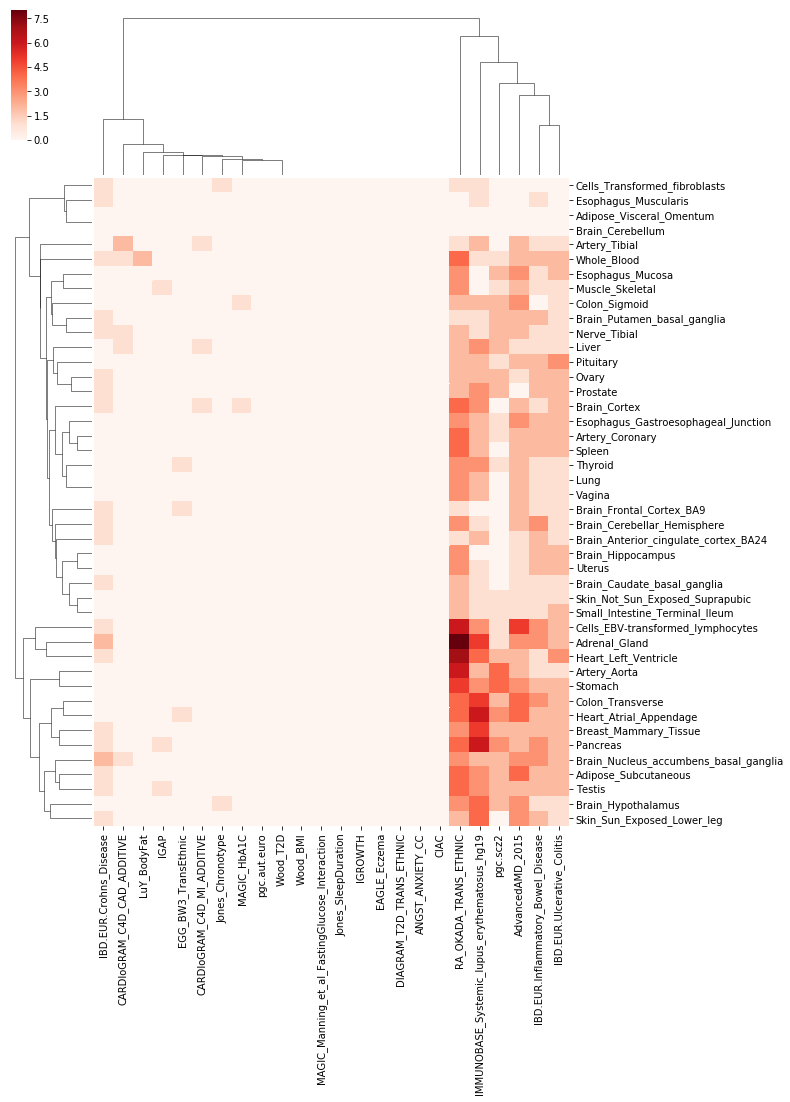

In [10]:
import seaborn.apionly as sns
import matplotlib.pyplot as plt
% matplotlib inline

sns.clustermap(pd.DataFrame(count_mat, index=id2ph, columns = id2tissue).T, cmap = 'Reds', figsize = (10, 15))
plt.show()

In [11]:
for c, p in zip(count_mat.sum(axis = 1), id2ph):
    print p, c

ANGST_ANXIETY_CC 0.0
AdvancedAMD_2015 87.0
CARDIoGRAM_C4D_CAD_ADDITIVE 6.0
CARDIoGRAM_C4D_MI_ADDITIVE 3.0
CIAC 0.0
DIAGRAM_T2D_TRANS_ETHNIC 0.0
EAGLE_Eczema 0.0
EGG_BW3_TransEthnic 3.0
IBD.EUR.Crohns_Disease 23.0
IBD.EUR.Inflammatory_Bowel_Disease 69.0
IBD.EUR.Ulcerative_Colitis 65.0
IGAP 3.0
IGROWTH 0.0
IMMUNOBASE_Systemic_lupus_erythematosus_hg19 97.0
Jones_Chronotype 2.0
Jones_SleepDuration 0.0
LuY_BodyFat 2.0
MAGIC_HbA1C 2.0
MAGIC_Manning_et_al_FastingGlucose_Interaction 0.0
RA_OKADA_TRANS_ETHNIC 129.0
Wood_BMI 0.0
Wood_T2D 0.0
pgc.aut.euro 0.0
pgc.scz2 52.0


In [45]:
t0 = id2tissue[29]
fea_mat = np.zeros((len(id2ph), len(res_all[(p, t0)])))

for (p, t), item in res_all.items():
    if t != t0:
        continue
        
    fea_mat[ph2id[p], :] = np.array(item)


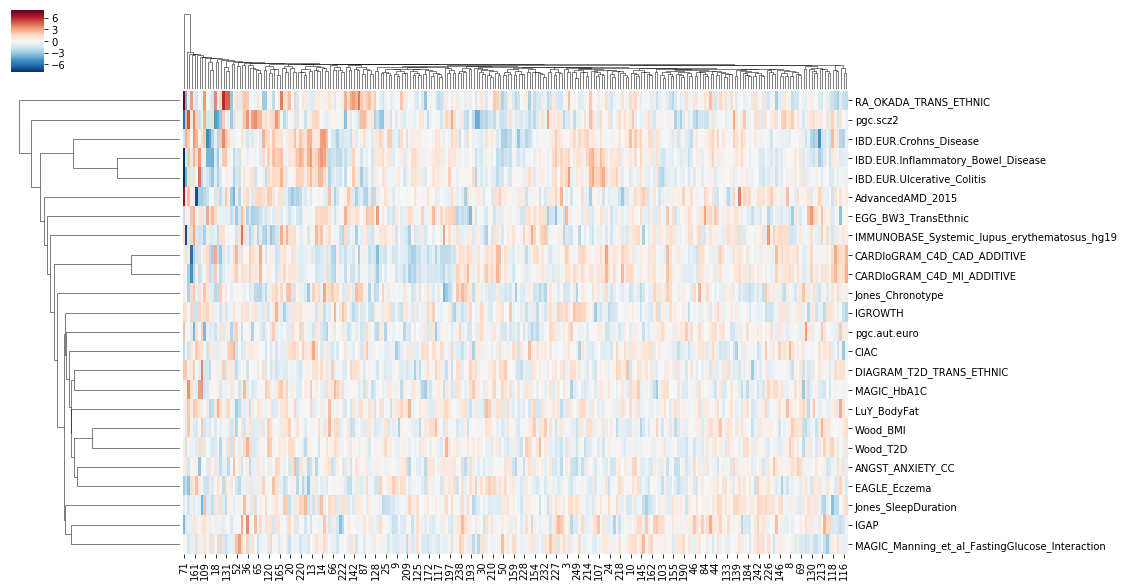

In [46]:
import seaborn.apionly as sns
import matplotlib.pyplot as plt
% matplotlib inline

sns.clustermap(pd.DataFrame(fea_mat, index=id2ph), cmap = 'RdBu_r', figsize = (15, 10), vmax = 8.0, vmin = -8.)
plt.show()

In [47]:
t0

u'Nerve_Tibial'

In [ ]:

with open('ensembl2genename.p', 'rb') as reader:
    gid2gn = pickle.load(reader)


for c, _ in Counter(dfm[1]).most_common(10):
    print c
    
    for i in np.where(dfm[1] == c)[0]:
        g = dfm[0].iloc[i]
        print gid2gn[g]
    print

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

plt.hist(res_ratio, bins = 20)
plt.show()

In [ ]:
import seaborn.apionly as sns

sns.clustermap(eigen_genes, cmap = 'RdBu_r', figsize = (15, 15), metric='correlation', vmax = 8.0, vmin = -8.0)
plt.show()

In [ ]:
res_all = [res_all[ph] for ph in id2ph]

In [ ]:
res_all = np.array(res_all)

In [ ]:
import seaborn.apionly as sns
import matplotlib.pyplot as plt
% matplotlib inline

sns.clustermap(res_all, cmap = 'RdBu_r', vmax = 10., vmin = -10.0)
plt.show()

In [ ]:
np.sum(np.abs(res_all) > 5.0)

In [ ]:
len(id2ph)

In [ ]:
np.sum(np.abs(res_all) > 5.0, axis = 1)

In [ ]:
np.sum(np.abs(res_all) > 5.0, axis = 0)